In [23]:
import numpy as np
import matplotlib.pyplot as plt
from hmlstm_network import HMLSTMNetwork
import tensorflow as tf
from text_input_utils import prepare_inputs
import tensorflow as tf
from string import ascii_lowercase

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Regression example

In [168]:
# simulate multiresolution data
num_signals = 100
signal_length = 100
x = np.linspace(0, 120 * np.pi, signal_length)
signals = [np.random.normal(0, .5, size=signal_length) +
           (2 * np.sin(.6 * x + np.random.random() * 100 * np.pi))
           + (5 * np.sin(.1* x + np.random.random() * 100 * np.pi))
           +( 10 * np.sin(.03 * x + np.random.random() * 100 * np.pi))
    for _ in range(num_signals)]

split = int(num_signals * .8)
train = signals[:split]
test = signals[split:]

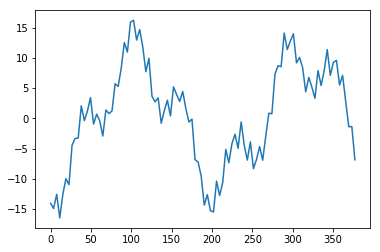

In [169]:
# example signal
plt.plot(x, signals[2]);

In [170]:
# prepare data
train_batches_in = []
train_batches_out = []
batch_size = 10
start = 0
while start + batch_size < len(train):
    batch = train[start: start + batch_size]
    
    train_batches_in.append(np.array([s[:-1] for s in batch]).reshape(batch_size, -1, 1))
    train_batches_out.append(np.array([s[1:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size
    
    
batch_size = 1
start = 0
test_batches_in = []
test_batches_out = []
while start + batch_size < len(test):
    batch = test[start: start + batch_size]
    
    test_batches_in.append(np.array([s[:-1] for s in batch]).reshape(batch_size, -1, 1))
    test_batches_out.append(np.array([s[1:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size

In [105]:
tf.reset_default_graph()
network = HMLSTMNetwork(input_size=1, task='regression', hidden_state_sizes=10,
                       embed_size=15, out_hidden_size=10, num_layers=3)

In [171]:
test_batches_in = np.swapaxes(np.array( test_batches_in ), 1, 2)
test_batches_out = np.swapaxes(np.array( test_batches_out ), 1, 2)
train_batches_in = np.swapaxes(np.array( train_batches_in ), 1, 2)
train_batches_out = np.swapaxes(np.array( train_batches_out ), 1, 2)

In [172]:
network.train(train_batches_in, train_batches_out, epochs=3, load_vars_from_disk=True)

./hmlstm_ckpt
loading variables...
INFO:tensorflow:Restoring parameters from ./hmlstm_ckpt
Epoch 0
loss: 11.931
loss: 11.8724
loss: 11.194
loss: 11.0086
loss: 12.0902
loss: 12.0628
loss: 11.369
Epoch 1
loss: 11.7667
loss: 11.6966
loss: 11.0742
loss: 10.8753
loss: 11.9521
loss: 11.9089
loss: 11.2223
Epoch 2
loss: 11.6346
loss: 11.5443
loss: 10.954
loss: 10.7584
loss: 11.8058
loss: 11.7722
loss: 11.0997
saving variables...


In [173]:
batch_num = 2

In [174]:
boundaries = network.predict_boundaries(test_batches_in[batch_num])
print(boundaries[0])

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   1.  1.  1.  0.  0.  0.  0.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1. 

In [175]:
# test that indicators are valid
# TODO: figure out why first element is sometimes invalid
b = boundaries[0]
for l in range(1, len(b)):
    for i in range(1, len(b[0])):
        if b[l][i] == 1.:
            if b[l][i - 1] == 0.\
            and b[l - 1][i] == 0. \
            and b[l - 1][i - 1] == 0.:
                print(l, i)
                raise ValueError("Something's not right")

In [176]:
predictions = network.predict(test_batches_in[batch_num])

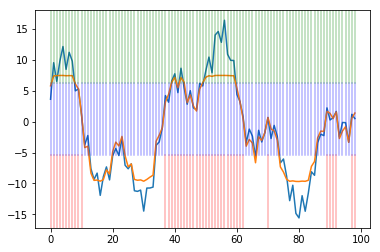

In [177]:
plt.plot(np.array(test_batches_in[batch_num])[:,0])
plt.plot(predictions.flatten())


colors = ['r', 'b', 'g', 'o']
for l, layer in enumerate(boundaries[0]):
    for i, indicator in enumerate(layer):
        if indicator == 1.:
            p = 1 / len(boundaries[0])
            plt.axvline(i, color=colors[l], ymin=(p*l), ymax=(p*(l + 1)), alpha=.3)

In [141]:
#NOTE: Underpowered networks make more use of boundaries

### Text classificaiton example

In [ ]:
tf.reset_default_graph()
network = HMLSTMNetwork(output_size=29, input_size=29,
                        embed_size=1024, out_hidden_size=500,
                        hidden_state_sizes=200)

In [ ]:
batch_size = 2
truncate_len = 100
num_layers = 3
num_batches = 100

inputs = prepare_inputs(
    batch_size=batch_size, truncate_len=truncate_len, num_batches=num_batches)

In [ ]:
# test on last input\
network.train(inputs[0][:-1], inputs[1][:-1], load_existing_vars=True)

In [ ]:
# predictions on last input
indicators = network.predict_boundaries(inputs[0][-1][0], reuse=True)
indicators

In [ ]:
# predictions on last input
predictions = network.predict(inputs[0][-1][0], reuse=True)

In [ ]:
def get_text(encoding):
    prediction = ''
    
    for char in np.squeeze(encoding):
        max_likelihood = np.where(char == np.max(char))[0][0]
        if max_likelihood < 26:
            prediction += ascii_lowercase[max_likelihood]
        elif max_likelihood == 26:
            prediction += ','
        elif max_likelihood == 27:
            prediction += '.'
        elif max_likelihood == 28:
            prediction += ' '
    
    return prediction

In [ ]:
get_text(predictions)

In [ ]:
get_text(inputs[0][-1][0][1:])